#### kaggle - Store Item Demand Forecasting Challenge / code review & study
- data : Sales

In [3]:
#데이터 로드
import pandas as pd

train = pd.read_csv('./train.csv', parse_dates=['date'])
test = pd.read_csv('./test.csv', parse_dates=['date'])

#### 데이터 형태 확인

In [96]:
train[train['item']==1]

,date,store,item,sales
1461,2017-01-01,1,1,19
1462,2017-01-02,1,1,15
1463,2017-01-03,1,1,10
1464,2017-01-04,1,1,16
1465,2017-01-05,1,1,14
...,...,...,...,...
18255,2017-12-27,10,1,19
18256,2017-12-28,10,1,12
18257,2017-12-29,10,1,23
18258,2017-12-30,10,1,26


In [4]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


#### 데이터 행/열 및 컬럼별 데이터 타입 확인

In [5]:
train.info()  # -- 913000행, 4열

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [6]:
test.info()  # -- 45000행, 4열(+id, -sales)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      45000 non-null  int64         
 1   date    45000 non-null  datetime64[ns]
 2   store   45000 non-null  int64         
 3   item    45000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.4 MB


#### train/test 날짜 기간 확인

In [16]:
print('train min date : ',train['date'].min().date())  # -- 2013-01-01 ~ 2017-12-31 일별 데이터
print('train max date : ',train['date'].max().date()) 

train min date :  2013-01-01
train max date :  2017-12-31


In [17]:
print('test min date : ',test['date'].min().date()) # -- 2018-01-01 ~ 2018-03-31 일별 데이터
print('test max date : ',test['date'].max().date())

test min date :  2018-01-01
test max date :  2018-03-31


#### train/test의 store, item 고유값 확인

In [10]:
train['store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [11]:
train['item'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
      dtype=int64)

In [12]:
test['store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [13]:
test['item'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
      dtype=int64)

## 일별 총 판매량 확인

In [24]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()

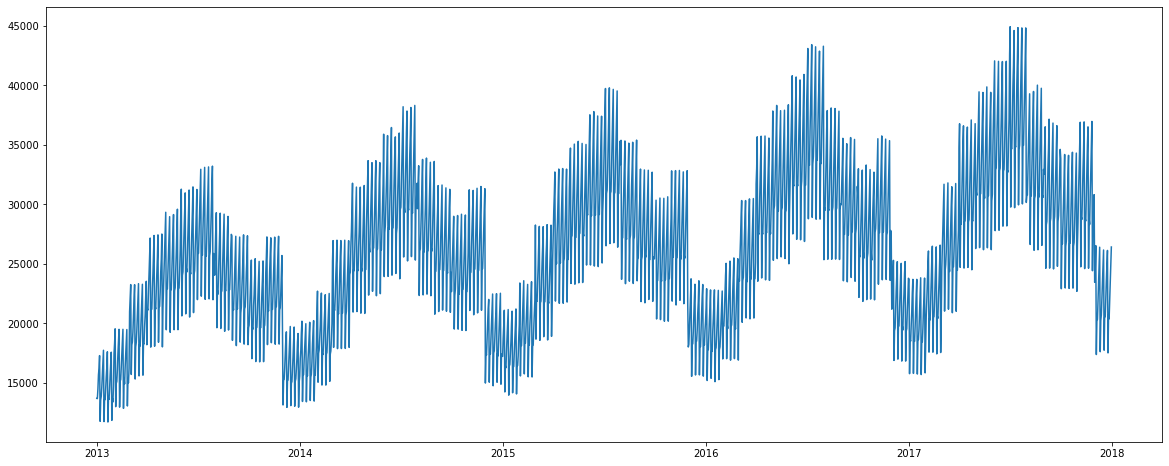

In [25]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(20,8))
plt.plot(daily_sales['date'], daily_sales['sales'])
plt.show()

## 일별, store별 총 판매량 확인

In [29]:
store_daliy_sales = train.groupby(['store','date'], as_index=False)['sales'].sum()

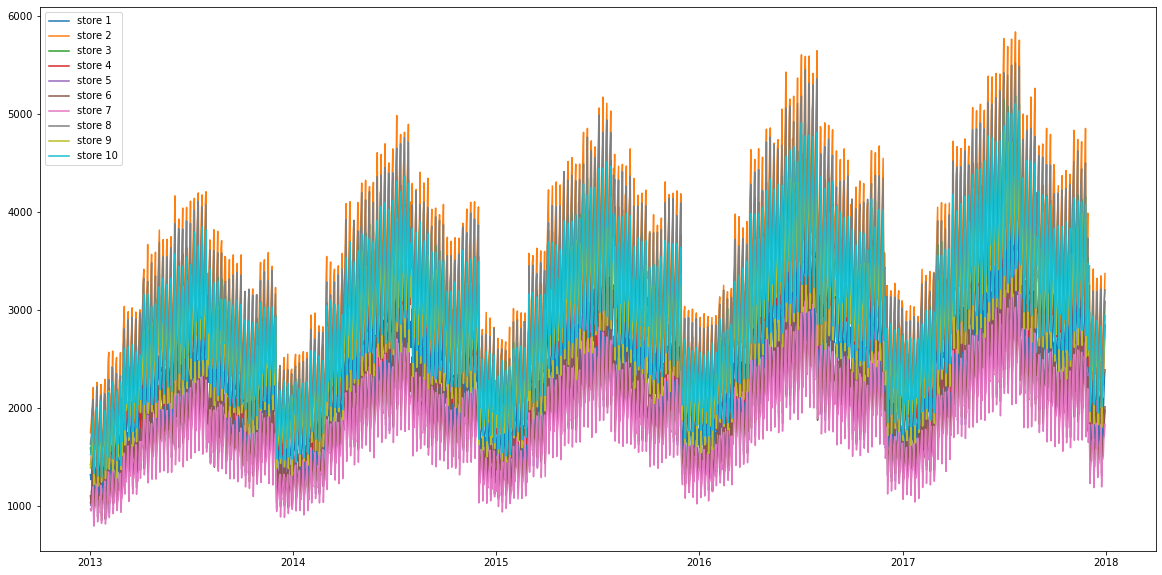

In [31]:
plt.figure(figsize=(20,10))

for i in range(1, 11):  # -- 스토어 수 만큼 반복하며, 스토어마다 그래프 하나씩 쌓기
    temp = store_daliy_sales[store_daliy_sales.store==i]
    plt.plot(temp['date'], temp['sales'], label = 'store %d' % i)

plt.legend()
plt.show()

## 일별, item별 총 판매량

In [34]:
item_daily_sales = train.groupby(['item','date'], as_index=False)['sales'].sum()

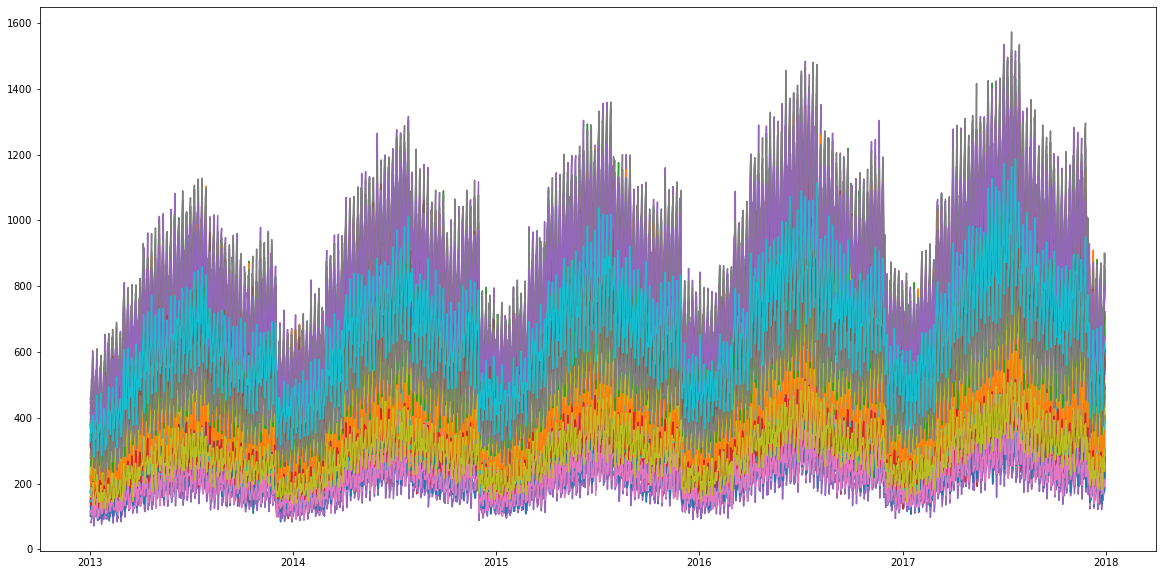

In [36]:
plt.figure(figsize=(20,10))

for i in range(1,51):  # -- 아이템의 수만큼 반복하고, 아이템마다 그래프를 그려 쌓음
    temp = item_daily_sales[item_daily_sales.item==i]
    plt.plot(temp['date'], temp['sales'], label= 'item %d' %i)
    
plt.show()

## 전처리

In [38]:
# 2017 데이터만 train으로 사용
train = train[train['date'] >= '2017-01-01']

### 모델 학습 프로세스 : 30일치로 90일 뒤를 학습한다.

In [45]:
#time series 형태로 변환

def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    
    for i in range(window, 0, -1):
        cols.append(data.shift(i))  #i만큼 아래로 밀어낸 데이터를 cols에 삽입 -- cols[0~i]
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]  #i만큼 밀어낸 데이터의 컬럼명을 순차적으로 삽입
    
    #shift 적용하지 않은 데이터를 마지막으로 삽입
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    
    #lag만큼 당겨올린(shift에 마이너스 인자가 입력되면 위로 숫자만큼 당겨올라감) 데이터 삽입
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col,lag)) for col in data.columns]
    
    #삽입한 모든 데이터를 각각의 컬럼으로(옆으로 붙이기) 데이터프레임화 함
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    
    if dropnan:   #NA가 있는 모든 행 삭제
        agg.dropna(inplace=True)
    return agg

In [91]:
# 함수적용 -- 90일 이후의 값을 label로 사용하기 위해 lag를 90으로 잡아준다.
window = 29
lag = 90
series = series_to_supervised(train.drop('date', axis=1), window=window, lag=lag)

In [97]:
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window

#shift의 영향으로 서로 다른 item, store가 묶이는 데이터를 삭제
series = series[(series['item(t)'] == series[last_item])]
series = series[(series['store(t)'] == series[last_store])]

In [101]:
#삭제할 컬럼명 추출 -- 마지막 +lag 컬럼 
columns_to_drop = [('%s(t+%d)' % (col,lag)) for col in ['item', 'store']]

#모든 shift된 item, store 컬럼명 추출
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]

#추출한 컬럼명을 사용하여 컬럼 드랍
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)  # -- 현재 시점 item, store 컬럼 추가 드랍

In [102]:
series # -- shift된 sales 컬럼만 남음

,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),...,sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t),sales(t+90)
1490,19.0,15.0,10.0,16.0,14.0,24.0,14.0,...,14.0,13.0,10.0,16.0,24.0,9,33.0
1491,15.0,10.0,16.0,14.0,24.0,14.0,20.0,...,13.0,10.0,16.0,24.0,9.0,17,15.0
1492,10.0,16.0,14.0,24.0,14.0,20.0,18.0,...,10.0,16.0,24.0,9.0,17.0,15,21.0
1493,16.0,14.0,24.0,14.0,20.0,18.0,11.0,...,16.0,24.0,9.0,17.0,15.0,17,29.0
1494,14.0,24.0,14.0,20.0,18.0,11.0,14.0,...,24.0,9.0,17.0,15.0,17.0,24,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912905,79.0,89.0,96.0,92.0,102.0,60.0,81.0,...,97.0,99.0,63.0,79.0,80.0,82,63.0
912906,89.0,96.0,92.0,102.0,60.0,81.0,79.0,...,99.0,63.0,79.0,80.0,82.0,90,59.0
912907,96.0,92.0,102.0,60.0,81.0,79.0,78.0,...,63.0,79.0,80.0,82.0,90.0,103,74.0
912908,92.0,102.0,60.0,81.0,79.0,78.0,97.0,...,79.0,80.0,82.0,90.0,103.0,99,62.0


In [106]:
#pandas view 옵션 설정 -- 최대 컬럼 확인 옵셜 (최대 20개 컬럼까지 가능)
pd.set_option('display.max_columns', 20)

In [107]:
series

,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t),sales(t+90)
1490,19.0,15.0,10.0,16.0,14.0,24.0,14.0,20.0,18.0,11.0,...,21.0,9.0,18.0,14.0,13.0,10.0,16.0,24.0,9,33.0
1491,15.0,10.0,16.0,14.0,24.0,14.0,20.0,18.0,11.0,14.0,...,9.0,18.0,14.0,13.0,10.0,16.0,24.0,9.0,17,15.0
1492,10.0,16.0,14.0,24.0,14.0,20.0,18.0,11.0,14.0,17.0,...,18.0,14.0,13.0,10.0,16.0,24.0,9.0,17.0,15,21.0
1493,16.0,14.0,24.0,14.0,20.0,18.0,11.0,14.0,17.0,7.0,...,14.0,13.0,10.0,16.0,24.0,9.0,17.0,15.0,17,29.0
1494,14.0,24.0,14.0,20.0,18.0,11.0,14.0,17.0,7.0,16.0,...,13.0,10.0,16.0,24.0,9.0,17.0,15.0,17.0,24,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912905,79.0,89.0,96.0,92.0,102.0,60.0,81.0,79.0,78.0,97.0,...,72.0,89.0,97.0,97.0,99.0,63.0,79.0,80.0,82,63.0
912906,89.0,96.0,92.0,102.0,60.0,81.0,79.0,78.0,97.0,93.0,...,89.0,97.0,97.0,99.0,63.0,79.0,80.0,82.0,90,59.0
912907,96.0,92.0,102.0,60.0,81.0,79.0,78.0,97.0,93.0,96.0,...,97.0,97.0,99.0,63.0,79.0,80.0,82.0,90.0,103,74.0
912908,92.0,102.0,60.0,81.0,79.0,78.0,97.0,93.0,96.0,74.0,...,97.0,99.0,63.0,79.0,80.0,82.0,90.0,103.0,99,62.0


## Train/Validation Split

In [111]:
from sklearn.model_selection import train_test_split

#label 분리
labels = series['sales(t+90)']
#x 데이터에서 label 드랍
series = series.drop('sales(t+90)', axis=1)

X_train, X_val, y_train, y_val = train_test_split(series, labels.values, test_size=0.4, random_state=0)

In [112]:
print('train set : ',X_train.shape)
print('validation set : ',X_val.shape)

train set :  (100746, 30)
validation set :  (67164, 30)


# MLP
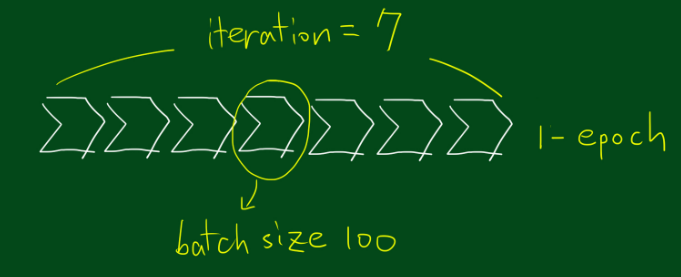

In [117]:
from tensorflow.keras import optimizers

# 파라미터 설정
epochs = 40   # 전체 트레이닝 셋이 신경망을 통과한 수
batch = 256  # 전체 트레이팅 셋에서 몇개씩 모델에 집어넣을건지, batch가 너무 크면 리소스 사용이 커지고 학습시간이 길어짐
             # batch 사이즈에 따라 반복횟수(iteration)가 정해짐 1 iteration마다 파라미터가 업데이트 됨
lr = 0.0003  # 이전 기울기를 다음 기울기에 반영하는 정도

#최적화 함수
adam = optimizers.Adam(lr)

In [118]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#model
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)

# Dense(units= , input_dim= , activation= )
# 레이어 층을 쌓는 기본 레이어
# units : 출력 뉴런의 수
# input_dim : 입력 뉴런의 수  -- 처음에 units, input_dim을 정해주면 이후에는 출력 뉴런 수에 맞게 입력 뉴런수가 정해짐
# activation : 활성화 함수 -- relu(은닉층으로 학습), sigmoid(이진분류문제), softmax(클래스 분류 문제)
#                          -- 마지막층 외에는 거의 다 relu로 학습함

In [119]:
#모델 확인
model_mlp.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               3100      
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


In [120]:
#모델 학습
mlp_history = model_mlp.fit(X_train.values, y_train, 
                            validation_data=(X_val, y_val), 
                            epochs=epochs, 
                            verbose=2)
#verbose  :  0 = silent, 1 = progress bar, 2 = one line per epoch.

Epoch 1/40
3149/3149 - 4s - loss: 509.3671 - val_loss: 389.9959 - 4s/epoch - 1ms/step
Epoch 2/40
3149/3149 - 5s - loss: 375.9555 - val_loss: 364.4156 - 5s/epoch - 2ms/step
Epoch 3/40
3149/3149 - 4s - loss: 362.8701 - val_loss: 356.9389 - 4s/epoch - 1ms/step
Epoch 4/40
3149/3149 - 4s - loss: 359.2576 - val_loss: 354.6808 - 4s/epoch - 1ms/step
Epoch 5/40
3149/3149 - 7s - loss: 356.6482 - val_loss: 354.6055 - 7s/epoch - 2ms/step
Epoch 6/40
3149/3149 - 5s - loss: 354.7754 - val_loss: 353.8872 - 5s/epoch - 2ms/step
Epoch 7/40
3149/3149 - 6s - loss: 354.0041 - val_loss: 351.1522 - 6s/epoch - 2ms/step
Epoch 8/40
3149/3149 - 6s - loss: 352.9252 - val_loss: 353.4116 - 6s/epoch - 2ms/step
Epoch 9/40
3149/3149 - 6s - loss: 352.6057 - val_loss: 348.7817 - 6s/epoch - 2ms/step
Epoch 10/40
3149/3149 - 5s - loss: 351.8826 - val_loss: 352.5067 - 5s/epoch - 2ms/step
Epoch 11/40
3149/3149 - 4s - loss: 350.8694 - val_loss: 348.5530 - 4s/epoch - 1ms/step
Epoch 12/40
3149/3149 - 6s - loss: 350.4065 - val_lo

In [121]:
#train/val 셋의 예측값 가져오기
mlp_train_pred =  model_mlp.predict(X_train.values)
mlp_val_pred = model_mlp.predict(X_val.values)

In [138]:
y_train_ = pd.DataFrame({'y_true':y_train,
                       'y_pred':mlp_train_pred.reshape(mlp_train_pred.shape[0])}).set_index(X_train.index).sort_index()

y_train_ = pd.merge(y_train_, train, 
                    left_index=True,  # 인덱스 기준으로 병합
                   right_index=True,
                   how='left')

In [139]:
y_train_  # date : 학습한 30일의 마지막 날짜, true는 +90일 값 pred는 +90일 후를 예측한 값

,y_true,y_pred,date,store,item,sales
1491,15.0,17.644854,2017-01-31,1,1,17
1492,21.0,16.187822,2017-02-01,1,1,15
1493,29.0,17.375650,2017-02-02,1,1,17
1494,19.0,22.900049,2017-02-03,1,1,24
1495,28.0,21.264366,2017-02-04,1,1,25
...,...,...,...,...,...,...
912902,76.0,79.651421,2017-09-25,10,50,63
912903,51.0,56.547108,2017-09-26,10,50,79
912904,41.0,63.188011,2017-09-27,10,50,80
912905,63.0,65.042755,2017-09-28,10,50,82


In [143]:
y_val_ = pd.DataFrame({'y_true':y_val,
                      'y_pred':mlp_val_pred.reshape(mlp_val_pred.shape[0]),}).set_index(X_val.index).sort_index()
y_val_ = pd.merge(y_val_, train,
                 left_index=True,
                 right_index=True,
                 how='left')

In [144]:
y_val_  # date : 학습한 30일의 마지막 날짜, true는 +90일 값 pred는 +90일 후를 예측한 값

,y_true,y_pred,date,store,item,sales
1490,33.0,22.111523,2017-01-30,1,1,9
1496,34.0,28.243313,2017-02-05,1,1,25
1502,26.0,22.104872,2017-02-11,1,1,18
1504,32.0,25.733160,2017-02-13,1,1,11
1505,17.0,18.306358,2017-02-14,1,1,15
...,...,...,...,...,...,...
912890,67.0,62.703327,2017-09-13,10,50,84
912896,53.0,60.312340,2017-09-19,10,50,84
912906,59.0,69.741714,2017-09-29,10,50,90
912908,62.0,84.417503,2017-10-01,10,50,99


## 성능 확인

In [147]:
from sklearn import metrics
import numpy as np

def scoring(y_true, y_pred):
    r2 = round(metrics.r2_score(y_true, y_pred) * 100, 3)
    corr = round(np.corrcoef(y_true, y_pred)[0,1], 3)
    mape = round(metrics.mean_absolute_percentage_error(y_true, y_pred)*100, 3)
    rmse = round(metrics.mean_squared_error(y_true, y_pred, squared=False), 3)
    
    df = pd.DataFrame({
        'R2':r2,
        'Corr':corr,
        'RMSE':rmse,
        'MAPE':mape
    },
    index=[0])
    
    return df

In [148]:
#train 성능
scoring(y_train_.y_true, y_train_.y_pred)

,R2,Corr,RMSE,MAPE
0,66.335,0.815,18.349,29.564


In [149]:
#validation 성능
scoring(y_val_.y_true, y_val_.y_pred)

,R2,Corr,RMSE,MAPE
0,65.639,0.811,18.479,29.708


## 예측값 그래프로 확인

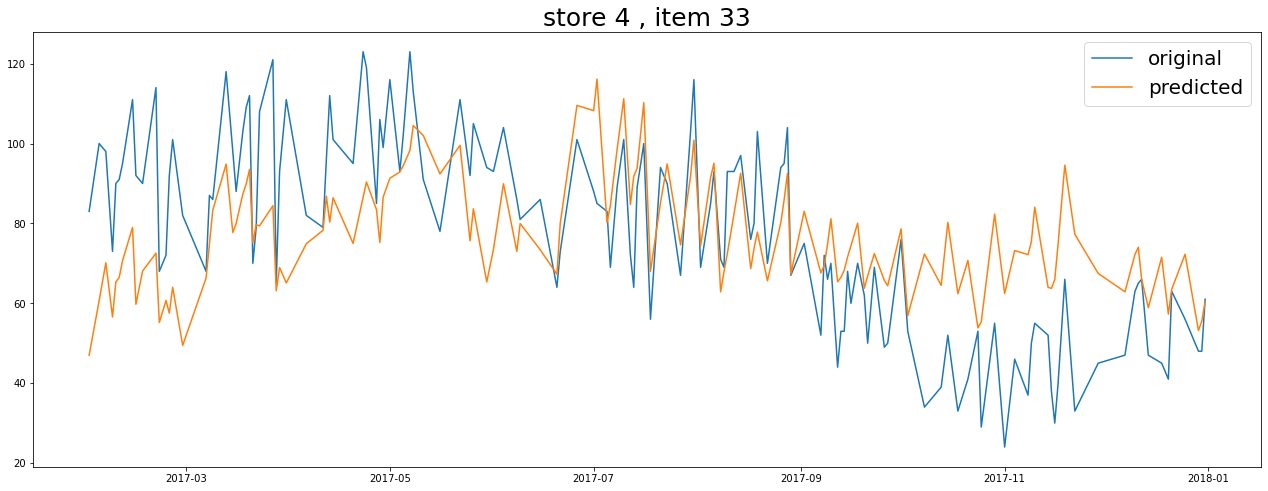

In [162]:
check_store = 4
check_item = 33

plt.figure(figsize=(22,8))

#실제값 그래프
plt.plot(y_val_.loc[(y_val_.store == check_store) & (y_val_.item == check_item)].sort_values('date').date,
        y_val_.loc[(y_val_.store == check_store) & (y_val_.item == check_item)].sort_values('date').y_true,
        label='original')
#예측값 그래프
plt.plot(y_val_.loc[(y_val_.store ==check_store) & (y_val_.item == check_item)].sort_values('date').date,
        y_val_.loc[(y_val_.store == check_store) & (y_val_.item == check_item)].sort_values('date').y_pred,
        label='predicted')

plt.title('store %s , item %d' %(check_store, check_item), fontsize=25)
plt.legend(fontsize=20)

plt.show()

# LSTM

In [166]:
#3차원으로 shape 변형
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1],1))
X_val_series = X_val.values.reshape((X_val.shape[0], X_val.shape[1],1))

In [172]:
from tensorflow.keras.layers import LSTM

#모델
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)

In [173]:
model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
